<a href="https://colab.research.google.com/github/LMY014/Cogs185_Final/blob/main/blip_sd_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision ftfy regex tqdm git+https://github.com/openai/CLIP.git
!pip install scipy
!pip install datasets
!pip install evaluate rouge_score

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_sjr1431
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_sjr1431
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch, json, os, random
from torchvision import datasets
from PIL import Image
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
from diffusers import StableDiffusionPipeline
from google.colab import drive

drive.mount('/content/drive')
blip_model_path = "/content/drive/MyDrive/blip_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained(blip_model_path, local_files_only=True)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_path, local_files_only=True).to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Mounted at /content/drive


In [ ]:
import torchvision.transforms as transforms
from torchvision.models.inception import inception_v3
from torch.nn import functional as F
from PIL import Image
import os
from tqdm import tqdm
import clip
import numpy as np
from scipy.stats import entropy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cifar
cifar = datasets.CIFAR10(root="data/", train=True, download=True)


100%|██████████| 170M/170M [00:01<00:00, 98.7MB/s]


In [ ]:

# Step 0: Function to clean repeated words in BLIP captions
def clean_caption(text):
    words = text.strip().split()
    cleaned_words = [words[0]] if words else []
    for w in words[1:]:
        if w != cleaned_words[-1]:
            cleaned_words.append(w)
    return " ".join(cleaned_words)

# Step 1: Modify captions with styles and noise
def modify_caption(caption):
    styles = ["professional photo", "animated version", "art style", "magazine look"]
    noise = ["random objects", "blurry light", "chaotic texture", "random street"]
    return {
        "original_caption": caption,
        "style_caption": caption + ", " + random.choice(styles),
        "noisy_caption": caption + ", " + random.choice(noise)
    }

# Step 2: Generate original and modified captions
captions = {}
os.makedirs("captions", exist_ok=True)

for idx in tqdm(range(40)):
    image = cifar[idx][0].resize((224, 224)).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs)
    raw_caption = processor.decode(out[0], skip_special_tokens=True)
    cleaned_caption = clean_caption(raw_caption)
    captions[f"cifar10_{idx}.png"] = modify_caption(cleaned_caption)

with open("captions/cifar10_captions.json", "w") as f:
    json.dump(captions, f, indent=2)


100%|██████████| 40/40 [00:09<00:00,  4.36it/s]


In [ ]:
# Step 2: Generate images with Stable Diffusion
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
os.makedirs("outputs_sd/cifar10/original", exist_ok=True)
os.makedirs("outputs_sd/cifar10/style", exist_ok=True)
os.makedirs("outputs_sd/cifar10/noisy", exist_ok=True)

for name, data in captions.items():
    # Original caption → SD image
    image_orig = pipe(data["original_caption"]).images[0]
    image_orig.save(os.path.join("outputs_sd/cifar10/original", name))

    # Style-modified caption → SD image
    image_style = pipe(data["style_caption"]).images[0]
    image_style.save(os.path.join("outputs_sd/cifar10/style", name))

    # Noisy caption → SD image
    image_noise = pipe(data["noisy_caption"]).images[0]
    image_noise.save(os.path.join("outputs_sd/cifar10/noisy", name))

# Step 3: Recaption all generated images
regen_captions = {"original": {}, "style": {}, "noisy": {}}

for name in tqdm(captions.keys()):
    for variant in ["original", "style", "noisy"]:
        path = os.path.join(f"outputs_sd/cifar10/{variant}", name)
        image = Image.open(path).resize((224, 224)).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        out = blip_model.generate(**inputs)
        regen_captions[variant][name] = processor.decode(out[0], skip_special_tokens=True)

os.makedirs("regenerated_captions", exist_ok=True)
with open("regenerated_captions/cifar10_sd_captions_extended.json", "w") as f:
    json.dump(regen_captions, f, indent=2)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:24<00:00,  1.61it/s]


In [ ]:
import evaluate
import json
import pandas as pd

# Load ROUGE metric
rouge = evaluate.load("rouge")

# Load original and regenerated captions
with open("captions/cifar10_captions.json", "r") as f:
    original_caps = json.load(f)

with open("regenerated_captions/cifar10_sd_captions_extended.json", "r") as f:
    recaptioned = json.load(f)

# Initialize results
results = {
    "image_name": [],
    "rougeL_orig_vs_recap_orig": [],
    "rougeL_style_vs_recap_style": [],
    "rougeL_noisy_vs_recap_noisy": [],
    "rougeL_orig_vs_recap_style": [],
    "rougeL_orig_vs_recap_noisy": []
}

def get_rougeL(pred, ref):
    score = rouge.compute(predictions=[pred], references=[ref], use_stemmer=True)
    return score["rougeL"]

# Compute all 5 comparisons
for name in original_caps:
    orig_cap = original_caps[name]["original_caption"]
    style_cap = original_caps[name]["style_caption"]
    noisy_cap = original_caps[name]["noisy_caption"]

    rec_orig = recaptioned["original"][name]
    rec_style = recaptioned["style"][name]
    rec_noisy = recaptioned["noisy"][name]

    results["image_name"].append(name)
    results["rougeL_orig_vs_recap_orig"].append(get_rougeL(rec_orig, orig_cap))
    results["rougeL_style_vs_recap_style"].append(get_rougeL(rec_style, style_cap))
    results["rougeL_noisy_vs_recap_noisy"].append(get_rougeL(rec_noisy, noisy_cap))
    results["rougeL_orig_vs_recap_style"].append(get_rougeL(rec_style, orig_cap))
    results["rougeL_orig_vs_recap_noisy"].append(get_rougeL(rec_noisy, orig_cap))

# Save results
df = pd.DataFrame(results)
df.to_csv("caption_consistency_rouge.csv", index=False)



In [ ]:
# Load CLIP
clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)

# Load InceptionV3
inception = inception_v3(pretrained=True, transform_input=False).to(device)
inception.eval()


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 55.4MiB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 208MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
def load_image(path, size=(299, 299), for_clip=False):
    image = Image.open(path).convert("RGB")
    if for_clip:
        return preprocess_clip(image).unsqueeze(0).to(device)
    else:
        transform = transforms.Compose([
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor()
        ])
        return transform(image).unsqueeze(0).to(device)


In [ ]:
def get_inception_score(images, splits=1):
    preds = []
    with torch.no_grad():
        for img in tqdm(images):
            img = load_image(img)
            pred = inception(img)
            pred = F.softmax(pred, dim=1)
            preds.append(pred.cpu().numpy())
    preds = np.concatenate(preds, axis=0)

    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k+1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = [entropy(pyx, py) for pyx in part]
        split_scores.append(np.exp(np.mean(scores)))
    return np.mean(split_scores), np.std(split_scores)


In [ ]:
def compute_clip_similarity(image_paths, captions):
    scores = []
    with torch.no_grad():
        for path, caption in tqdm(zip(image_paths, captions), total=len(image_paths)):
            image_input = load_image(path, for_clip=True)
            text_input = clip.tokenize(caption).to(device)
            image_features = clip_model.encode_image(image_input)
            text_features = clip_model.encode_text(text_input)
            sim = F.cosine_similarity(image_features, text_features).item()
            scores.append(sim)
    return scores


In [ ]:
# Path setup
base_path = "outputs_sd/cifar10/"
original_images = [os.path.join(base_path, "original", f) for f in os.listdir(base_path + "original")]
noisy_images = [os.path.join(base_path, "noisy", f) for f in os.listdir(base_path + "noisy")]
style_images = [os.path.join(base_path, "style", f) for f in os.listdir(base_path + "style")]

# ---- Inception Score ----
inception_orig, std_orig = get_inception_score(original_images)
inception_style, std_style = get_inception_score(style_images)
inception_noisy, std_noisy = get_inception_score(noisy_images)

# ---- CLIP Similarity ----
with open("captions/cifar10_captions.json", "r") as f:
    orig_caps = json.load(f)

clip_scores_orig = compute_clip_similarity(original_images, [orig_caps[f]["original_caption"] for f in orig_caps])
clip_scores_noisy = compute_clip_similarity(noisy_images, [orig_caps[f]["noisy_caption"] for f in orig_caps])
clip_scores_style = compute_clip_similarity(style_images, [orig_caps[f]["style_caption"] for f in orig_caps])


100%|██████████| 40/40 [00:01<00:00, 31.87it/s]


In [ ]:
import pandas as pd


clip_data = {
    "image_name": list(orig_caps.keys()),
    "clip_original": clip_scores_orig,
    "clip_style": clip_scores_style,
    "clip_noisy": clip_scores_noisy,
    "inception_original": [inception_orig] * len(clip_scores_orig),
    "inception_style": [inception_style] * len(clip_scores_style),
    "inception_noisy": [inception_noisy] * len(clip_scores_orig),
}

df_clip = pd.DataFrame(clip_data)
df_clip.to_csv("clip_inception_per_image.csv", index=False)


In [ ]:
import pandas as pd

# Load files
df_rouge = pd.read_csv("caption_consistency_rouge.csv")
df_clip_inception = pd.read_csv("clip_inception_per_image.csv")

# Compute means
mean_rouge = {
    "ROUGE-L: orig vs recap_orig": df_rouge["rougeL_orig_vs_recap_orig"].mean(),
    "ROUGE-L: style vs recap_style": df_rouge["rougeL_style_vs_recap_style"].mean(),
    "ROUGE-L: noisy vs recap_noisy": df_rouge["rougeL_noisy_vs_recap_noisy"].mean(),
    "ROUGE-L: orig vs recap_style": df_rouge["rougeL_orig_vs_recap_style"].mean(),
    "ROUGE-L: orig vs recap_noisy": df_rouge["rougeL_orig_vs_recap_noisy"].mean()
}


mean_clip = {
    "CLIP (original)": df_clip_inception["clip_original"].mean(),
    "CLIP (style)": df_clip_inception["clip_style"].mean(),
    "CLIP (noisy)": df_clip_inception["clip_noisy"].mean()
}

mean_inception = {
    "Inception (original)": df_clip_inception["inception_original"].mean(),
    "Inception (style)": df_clip_inception["inception_style"].mean(),
    "Inception (noisy)": df_clip_inception["inception_noisy"].mean()
}

# Combine all
summary = {
    "Metric": list(mean_rouge.keys()) + list(mean_clip.keys()) + list(mean_inception.keys()),
    "Mean Score": list(mean_rouge.values()) + list(mean_clip.values()) + list(mean_inception.values())
}

df_summary = pd.DataFrame(summary)
df_summary.to_csv("summary_scores.csv", index=False)
print(df_summary)


                           Metric  Mean Score
0     ROUGE-L: orig vs recap_orig    0.649472
1   ROUGE-L: style vs recap_style    0.549939
2   ROUGE-L: noisy vs recap_noisy    0.569868
3    ROUGE-L: orig vs recap_style    0.616476
4    ROUGE-L: orig vs recap_noisy    0.627114
5                 CLIP (original)    0.165770
6                    CLIP (style)    0.194196
7                    CLIP (noisy)    0.179784
8            Inception (original)   14.724324
9               Inception (style)   11.399756
10              Inception (noisy)   11.237490


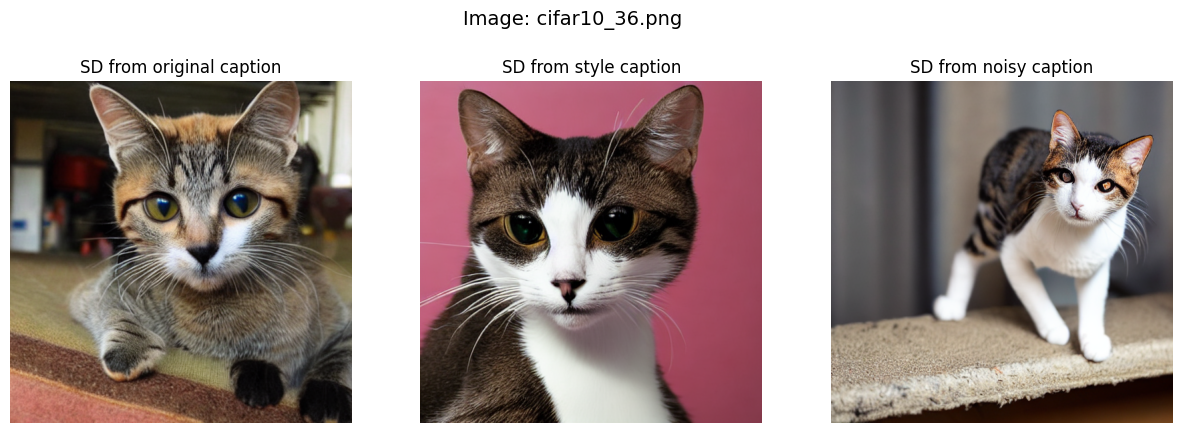

Original Caption: adopt a domestic cat in san
Style Caption: adopt a domestic cat in san, professional photo
Noisy Caption: adopt a domestic cat in san, blurry light

Recaptions:
  • From SD(original): a cat with blue eyes laying on a rug
  • From SD(style):    a cat with a white stripe
  • From SD(noisy):    a cat walking on a table


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import json
import pandas as pd

# Load your results
df_rouge = pd.read_csv("caption_consistency_rouge.csv")
df_clip = pd.read_csv("clip_inception_per_image.csv")
df = df_rouge.merge(df_clip, on="image_name")

# Normalize scores for each variant (lower = worse)
df["rouge_orig_norm"] = 1 - df["rougeL_orig_vs_recap_orig"]
df["rouge_style_norm"] = 1 - df["rougeL_style_vs_recap_style"]
df["rouge_noisy_norm"] = 1 - df["rougeL_noisy_vs_recap_noisy"]

df["clip_orig_norm"] = 1 - df["clip_original"]
df["clip_style_norm"] = 1 - df["clip_style"]
df["clip_noisy_norm"] = 1 - df["clip_noisy"]

# Combine drift scores for all 3 types
df["combined_drift"] = (
    df["rouge_orig_norm"] + df["clip_orig_norm"] +
    df["rouge_style_norm"] + df["clip_style_norm"] +
    df["rouge_noisy_norm"] + df["clip_noisy_norm"]
)

# Find top 1 worst drifting examples
worst = df.sort_values("combined_drift", ascending=False).head(1)["image_name"].tolist()


# Load captions and recaptions
with open("captions/cifar10_captions.json") as f:
    captions = json.load(f)
with open("regenerated_captions/cifar10_sd_captions_extended.json") as f:
    recaps = json.load(f)

def show_qualitative_example(image_name):
    # Paths to images
    base_path = "outputs_sd/cifar10"
    img_paths = {
        "original": f"{base_path}/original/{image_name}",
        "style": f"{base_path}/style/{image_name}",
        "noisy": f"{base_path}/noisy/{image_name}"
    }

    # Display images side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, variant in enumerate(["original", "style", "noisy"]):
        img = Image.open(img_paths[variant])
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"SD from {variant} caption")

    plt.suptitle(f"Image: {image_name}", fontsize=14)
    plt.show()

    # Print captions and recaptions
    print(f"\033[1mOriginal Caption:\033[0m {captions[image_name]['original_caption']}")
    print(f"\033[1mStyle Caption:\033[0m {captions[image_name]['style_caption']}")
    print(f"\033[1mNoisy Caption:\033[0m {captions[image_name]['noisy_caption']}")
    print()
    print("Recaptions:")
    print(f"  • From SD(original): {recaps['original'][image_name]}")
    print(f"  • From SD(style):    {recaps['style'][image_name]}")
    print(f"  • From SD(noisy):    {recaps['noisy'][image_name]}")

for name in worst:
    show_qualitative_example(name)

